# Sentiment Analysis Showdown: Custom LSTM vs. XLM-RoBERTa

In questo notebook confronteremo due approcci alla Sentiment Analysis sul dataset `mrev.csv`:

1.  **Baseline (Neural Network)**: Un modello LSTM bidirezionale con embeddings pre-addestrati (GloVe Twitter), ripreso dal precedente esperimento.
2.  **State-of-the-Art (Transformer)**: Il modello `xlm-roberta-base`, un Transformer multilingue fine-tunato sul nostro dataset.

Includeremo anche un'analisi esplorativa dei dati (EDA) con WordCloud.

In [17]:
# Installazione dipendenze (se necessario)
!pip install transformers datasets wordcloud gensim seaborn torch scikit-learn pandas matplotlib accelerate peft


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from peft import PeftModel, get_peft_model, LoraConfig, TaskType

# Configurazione Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading & EDA (Exploratory Data Analysis)

Dataset Size: 110
Classes: {'negative': 0, 'neutral': 1, 'positive': 2}


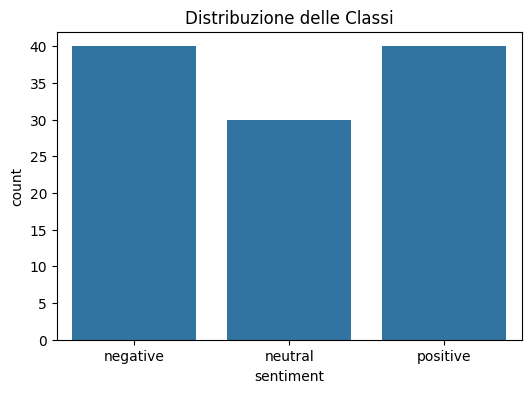

In [19]:
# Caricamento Dati
file_path = '../data/processed/mrev_clean.csv' #'../data/raw/mrev.csv'
df = pd.read_csv(file_path)

# Preprocessing base
df = df[['review_text', 'sentiment']].dropna()
df['review_text'] = df['review_text'].astype(str)
df['sentiment'] = df['sentiment'].str.lower()

# Mapping Sentiment (ordine fisso per evitare mismatch)
labels_order = ['negative', 'neutral', 'positive']
sentiment_map = {label: idx for idx, label in enumerate(labels_order)}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
df['label'] = df['sentiment'].map(sentiment_map)

print(f"Dataset Size: {len(df)}")
print(f"Classes: {sentiment_map}")

# Distribuzione Classi
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, order=labels_order)
plt.title('Distribuzione delle Classi')
plt.show()

In [20]:
# Suddivisione stratificata: 80% train/val, 20% test
train_val_df, test_df = train_test_split(
    df[['review_text', 'sentiment', 'label']],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Split ulteriore sul training set per creare la validation (80/20 -> 64/16 complessivi)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['label']
)

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")

Train size: 70 | Val size: 18 | Test size: 22


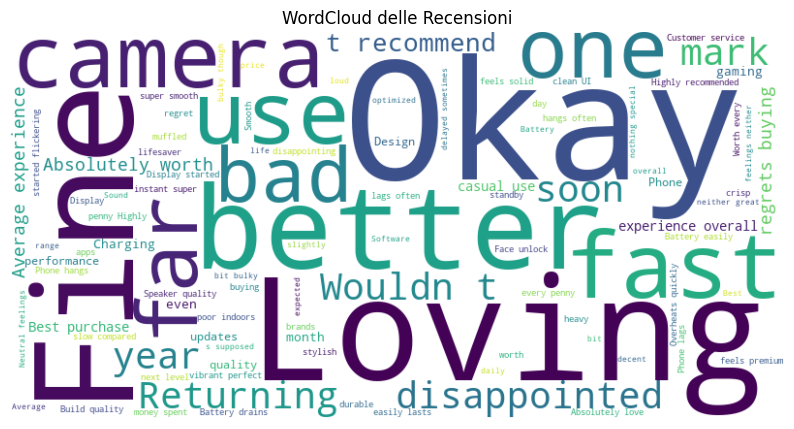

In [36]:
# Generazione WordCloud
text_combined = " ".join(review for review in df.review_text)

wordcloud = WordCloud(width=800, height=400, background_color ='white', max_words=200).generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud delle Recensioni")
plt.show()

## 2. Modello 1: Custom LSTM (con GloVe Twitter)

Replichiamo l'architettura del notebook precedente.

In [ ]:
# --- 2.1 Preprocessing specifico per LSTM ---
def clean_text_lstm(text):
    text = str(text).lower()
    # conserva emoji/emoticon rimuovendo solo url e caratteri di controllo
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[\r\n\t]+', ' ', text)
    text = re.sub(r'[^\w\s\U0001F300-\U0001FAFF]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Applica il preprocessing e tokenizza le tre partizioni

def add_tokens(df_in):
    df_out = df_in.copy()
    df_out['clean_text'] = df_out['review_text'].apply(clean_text_lstm)
    df_out['tokens'] = df_out['clean_text'].apply(lambda x: x.split())
    return df_out

train_df_lstm = add_tokens(train_df)
val_df_lstm = add_tokens(val_df)
test_df_lstm = add_tokens(test_df)

# Vocabolario costruito solo sul training set
all_words = [word for tokens in train_df_lstm['tokens'] for word in tokens]
word_counts = Counter(all_words)
min_freq = 2
vocab_list = sorted([k for k, v in word_counts.items() if v >= min_freq])
vocab = {word: i + 1 for i, word in enumerate(vocab_list)}
vocab_size = len(vocab) + 1

# Conversione Testo -> Indici
def text_to_indices(tokens, vocab, max_len=50):
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

max_seq_len = 50
X_train_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in train_df_lstm['tokens']])
y_train_lstm = train_df_lstm['label'].values
X_val_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in val_df_lstm['tokens']])
y_val_lstm = val_df_lstm['label'].values
X_test_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in test_df_lstm['tokens']])
y_test_lstm = test_df_lstm['label'].values

# Dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader_lstm = DataLoader(ReviewDataset(X_train_lstm, y_train_lstm), batch_size=32, shuffle=True)
val_loader_lstm = DataLoader(ReviewDataset(X_val_lstm, y_val_lstm), batch_size=32, shuffle=False)
test_loader_lstm = DataLoader(ReviewDataset(X_test_lstm, y_test_lstm), batch_size=32, shuffle=False)

# --- 2.2 Caricamento Embeddings GloVe ---
print("Caricamento GloVe Twitter... (potrebbe richiedere un po')")
try:
    glove_model = api.load("glove-twitter-100")
    embedding_dim = 100

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
except Exception as e:
    print(f"Errore caricamento GloVe: {e}. Uso embedding random.")
    embedding_dim = 100
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))

# --- 2.3 Definizione Modello ---
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        return self.fc(self.dropout(hidden))

# --- 2.4 Training Loop ---
model_lstm = SentimentLSTM(vocab_size, embedding_dim, 64, len(sentiment_map), embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print("Training LSTM...")
lstm_val_history = []
epochs = 5

for epoch in range(epochs):
    model_lstm.train()
    for X_b, y_b in train_loader_lstm:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model_lstm(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optimizer.step()

    # Validation
    model_lstm.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_b, y_b in val_loader_lstm:
            X_b = X_b.to(device)
            out = model_lstm(X_b)
            _, preds = torch.max(out, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_b.numpy())

    val_acc = accuracy_score(val_targets, val_preds)
    lstm_val_history.append(val_acc)
    print(f"LSTM Epoch {epoch + 1}: Val Accuracy {val_acc:.4f}")

# Test finale
model_lstm.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for X_b, y_b in test_loader_lstm:
        X_b = X_b.to(device)
        out = model_lstm(X_b)
        _, preds = torch.max(out, 1)
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(y_b.numpy())

lstm_test_acc = accuracy_score(test_targets, test_preds)
lstm_test_f1 = f1_score(test_targets, test_preds, average='weighted')
lstm_cm = confusion_matrix(test_targets, test_preds)
print(f"LSTM Test Accuracy: {lstm_test_acc:.4f} | F1-weighted: {lstm_test_f1:.4f}")

# Salvataggio checkpoint LSTM in ../models (overwrite)
lstm_ckpt_dir = os.path.abspath(os.path.join('..', 'models'))
os.makedirs(lstm_ckpt_dir, exist_ok=True)
lstm_ckpt_path = os.path.join(lstm_ckpt_dir, 'lstm_sentiment.ckpt')
torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'vocab': vocab,
    'sentiment_map': sentiment_map,
}, lstm_ckpt_path)
print(f"Checkpoint LSTM salvato in {lstm_ckpt_path}")

Caricamento GloVe Twitter... (potrebbe richiedere un po')
Training LSTM...
LSTM Epoch 1: Val Accuracy 0.4444
LSTM Epoch 2: Val Accuracy 0.6111
LSTM Epoch 3: Val Accuracy 0.7778
LSTM Epoch 4: Val Accuracy 0.7778
LSTM Epoch 5: Val Accuracy 0.8333
LSTM Test Accuracy: 0.7273 | F1-weighted: 0.7213
Checkpoint LSTM salvato in c:\Users\Gabs\Desktop\faboulus-interpretr\models\lstm_sentiment.ckpt


## 3. Modello 2: XLM-RoBERTa (Fine-Tuning)

Usiamo la libreria `transformers` per fine-tunare `xlm-roberta-base`.

In [29]:
# --- 3.1 Preparazione Dati per Transformers ---
from peft import LoraConfig, TaskType, get_peft_model
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

X_train_raw, y_train_raw = train_df['review_text'], train_df['label']
X_val_raw, y_val_raw = val_df['review_text'], val_df['label']
X_test_raw, y_test_raw = test_df['review_text'], test_df['label']

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=128)

# Creazione Dataset HuggingFace
train_dataset = HFDataset.from_dict({"text": X_train_raw.tolist(), "label": y_train_raw.tolist()})
val_dataset = HFDataset.from_dict({"text": X_val_raw.tolist(), "label": y_val_raw.tolist()})
test_dataset = HFDataset.from_dict({"text": X_test_raw.tolist(), "label": y_test_raw.tolist()})

train_tokenized = train_dataset.map(lambda x: tokenize_function(x['text']), batched=True)
val_tokenized = val_dataset.map(lambda x: tokenize_function(x['text']), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x['text']), batched=True)

# --- 3.2 Setup Trainer con LoRA ---
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(sentiment_map),
    id2label=reverse_sentiment_map,
    label2id=sentiment_map,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
).to(device)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    modules_to_save=["classifier"] # <--- FIX: Addestra e salva la testa di classificazione!
)
model_xlm = get_peft_model(base_model, peft_config)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {"accuracy": acc, "f1": f1}

xlm_ckpt_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora_checkpoints'))
xlm_final_dir = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
os.makedirs(xlm_ckpt_dir, exist_ok=True)
os.makedirs(xlm_final_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=xlm_ckpt_dir,
    eval_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    learning_rate=2e-5,
    save_strategy="epoch",
    save_total_limit=1,
    overwrite_output_dir=True,
    use_cpu=not torch.cuda.is_available()
 )
trainer = Trainer(
    model=model_xlm,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    compute_metrics=compute_metrics,
 )

# --- 3.3 Training ---
print("Training XLM-RoBERTa LoRA...")
trainer.train()

# Salva l'adapter LoRA (sovrascrive se esiste)
model_xlm.save_pretrained(xlm_final_dir)
tokenizer.save_pretrained(xlm_final_dir)

# Valutazione Finale su test set hold-out
print("Valutazione su test set (20%)...")
test_pred = trainer.predict(test_tokenized)
test_logits = test_pred.predictions
test_labels = test_pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)
xlm_test_acc = accuracy_score(test_labels, test_preds)
xlm_test_f1 = f1_score(test_labels, test_preds, average='weighted')
xlm_cm = confusion_matrix(test_labels, test_preds)
print(f"XLM-RoBERTa (LoRA) Test Accuracy: {xlm_test_acc:.4f} | F1-weighted: {xlm_test_f1:.4f}")

Map: 100%|██████████| 22/22 [00:00<00:00, 5270.13 examples/s]
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training XLM-RoBERTa LoRA...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.099404,0.333333,0.166667
2,1.100700,1.097336,0.333333,0.166667
3,1.111400,1.096331,0.333333,0.166667


Valutazione su test set (20%)...


XLM-RoBERTa (LoRA) Test Accuracy: 0.3636 | F1-weighted: 0.1939


## 4. Confronto Risultati

### Confusion matrix sul test set (20%)
Confrontiamo le confusion matrix complete per i due modelli sulle etichette reali del test set hold-out.

C:\Users\Gabs\AppData\Local\Temp\ipykernel_21368\4110909266.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=models, y=accuracies, palette='viridis')
C:\Users\Gabs\AppData\Local\Temp\ipykernel_21368\4110909266.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=models, y=f1_scores, palette='magma')


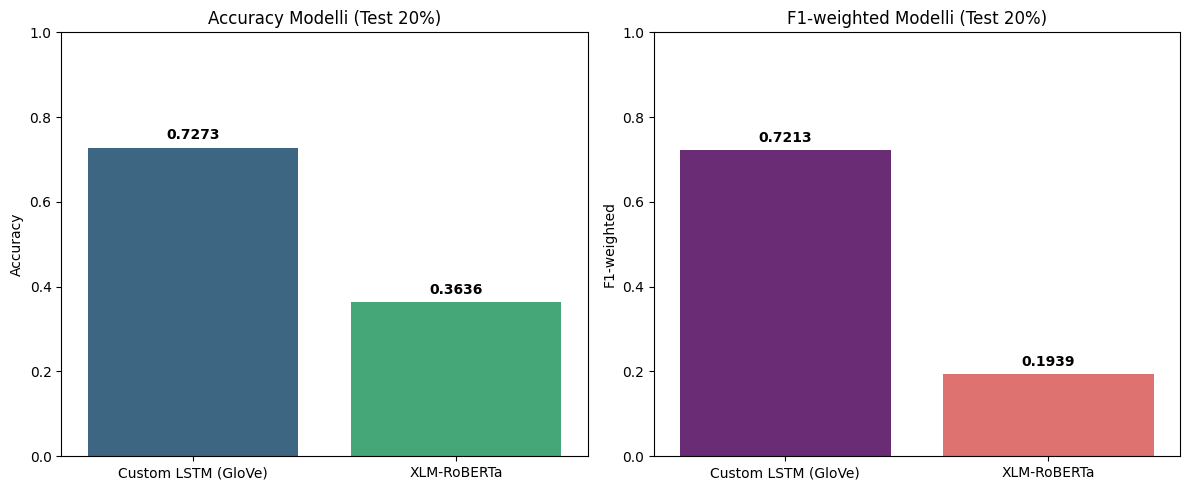

In [30]:
models = ['Custom LSTM (GloVe)', 'XLM-RoBERTa']
accuracies = [lstm_test_acc, xlm_test_acc]
f1_scores = [lstm_test_f1, xlm_test_f1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(ax=axes[0], x=models, y=accuracies, palette='viridis')
axes[0].set_ylim(0, 1)
axes[0].set_title('Accuracy Modelli (Test 20%)')
axes[0].set_ylabel('Accuracy')
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

sns.barplot(ax=axes[1], x=models, y=f1_scores, palette='magma')
axes[1].set_ylim(0, 1)
axes[1].set_title('F1-weighted Modelli (Test 20%)')
axes[1].set_ylabel('F1-weighted')
for i, v in enumerate(f1_scores):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

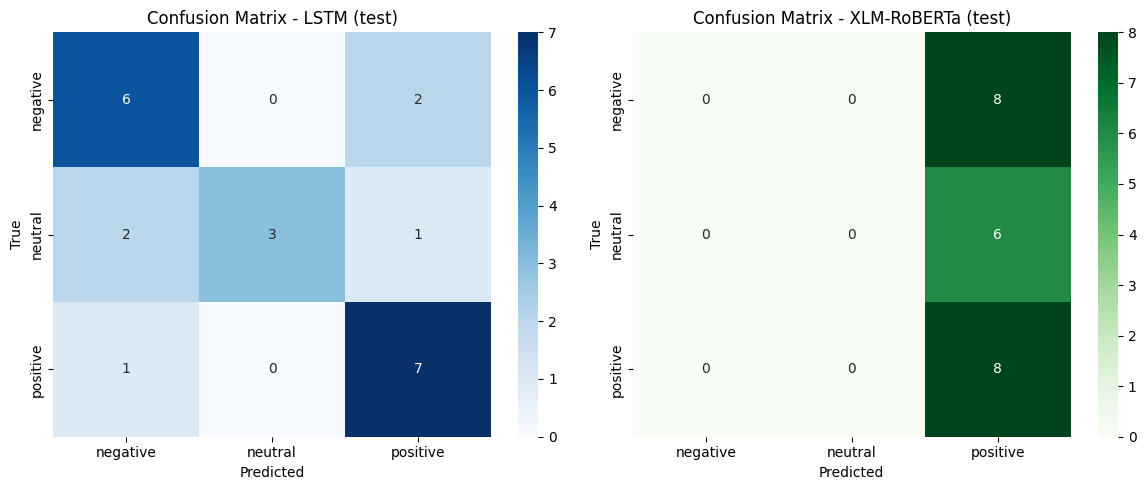

In [31]:
labels_order = list(reverse_sentiment_map.values())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM (test)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(xlm_cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title('Confusion Matrix - XLM-RoBERTa (test)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

## 5. Confronto rapido: LSTM vs BERT pre-addestrato sulle prime 30 righe

In [33]:
# Seleziona le prime 30 righe del test set hold-out
# (allineato con la regola 80/20)
eval_df = test_df_lstm.head(900).copy()
y_true = eval_df['sentiment'].str.lower().tolist()

# --- Predizioni LSTM sul sottoinsieme ---
X_eval_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in eval_df['tokens']])
lstm_preds = []
model_lstm.eval()
with torch.no_grad():
    for i in range(0, len(X_eval_lstm), 32):
        batch = torch.tensor(X_eval_lstm[i:i+32], dtype=torch.long).to(device)
        logits = model_lstm(batch)
        _, preds = torch.max(logits, 1)
        lstm_preds.extend([reverse_sentiment_map[p.item()].lower() for p in preds.cpu()])

# --- Predizioni BERT già addestrato (LoRA se presente) ---
lora_path = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
base_name = 'xlm-roberta-base'
id2label_fixed = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id_fixed = {v: k for k, v in id2label_fixed.items()}

bert_tokenizer = AutoTokenizer.from_pretrained(lora_path if os.path.exists(lora_path) else base_name)
bert_base = AutoModelForSequenceClassification.from_pretrained(
    base_name,
    num_labels=3,
    id2label=id2label_fixed,
    label2id=label2id_fixed,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
)
if os.path.exists(os.path.join(lora_path, 'adapter_config.json')):
    bert_model = PeftModel.from_pretrained(bert_base, lora_path)
else:
    bert_model = bert_base
bert_model.to(device)
bert_model.eval()

def predict_bert(texts, batch_size=8):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        with torch.no_grad():
            logits = bert_model(**inputs).logits
        class_ids = torch.argmax(logits, dim=-1).cpu().tolist()
        preds.extend([bert_model.config.id2label[c] for c in class_ids])
    return [p.lower() for p in preds]

bert_preds = predict_bert(eval_df['review_text'].tolist())

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
# Metriche di classificazione sulle prime 30 righe
labels_order = ['negative', 'neutral', 'positive']

def evaluate_run(name, preds):
    acc = accuracy_score(y_true, preds)
    print(f"\n{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_true, preds, labels=labels_order, target_names=labels_order, digits=3))
    return acc, confusion_matrix(y_true, preds, labels=labels_order)

lstm_acc, cm_lstm = evaluate_run('LSTM', lstm_preds)
bert_acc, cm_bert = evaluate_run('BERT (xlm-roberta + LoRA)', bert_preds)


LSTM - Accuracy: 0.7273
              precision    recall  f1-score   support

    negative      0.667     0.750     0.706         8
     neutral      1.000     0.500     0.667         6
    positive      0.700     0.875     0.778         8

    accuracy                          0.727        22
   macro avg      0.789     0.708     0.717        22
weighted avg      0.770     0.727     0.721        22


BERT (xlm-roberta + LoRA) - Accuracy: 0.3636
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000         8
     neutral      0.000     0.000     0.000         6
    positive      0.364     1.000     0.533         8

    accuracy                          0.364        22
   macro avg      0.121     0.333     0.178        22
weighted avg      0.132     0.364     0.194        22



c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Gabs\Desktop\faboulus-interpretr\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

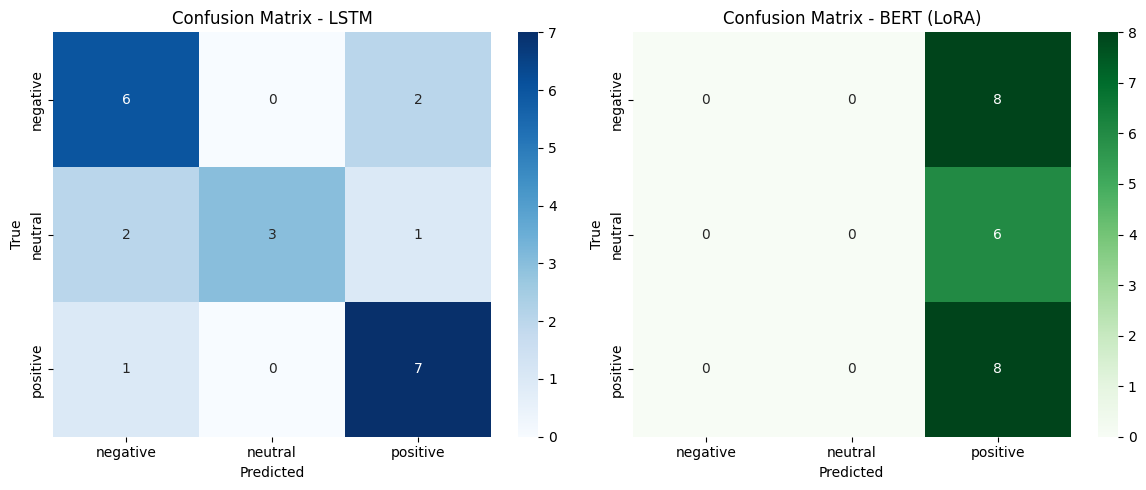

C:\Users\Gabs\AppData\Local\Temp\ipykernel_21368\983345494.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')


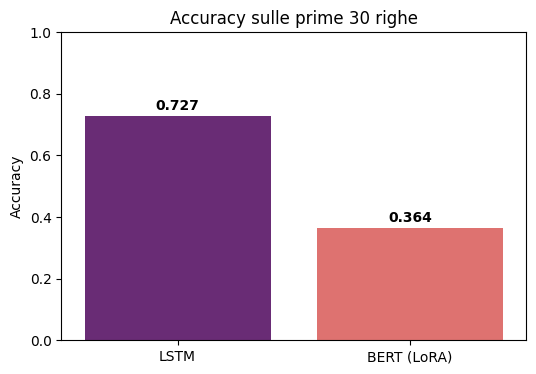

In [35]:
# Heatmap delle confusion matrix + confronto accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title('Confusion Matrix - BERT (LoRA)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

# Bar chart accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')
plt.ylim(0, 1)
for i, v in enumerate([lstm_acc, bert_acc]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.title('Accuracy sulle prime 30 righe')
plt.ylabel('Accuracy')
plt.show()